# Trying vector codings 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio.Data import IUPACData
from collections import defaultdict
from itertools import product, combinations
from scipy.spatial.distance import hamming
import scipy.stats as ss
import cvxpy as cp
import sys
import scipy.linalg as sl

sys.path.append("../") 
import doe_utils

# TEST MAKE AMINO ACID WORLD SMALL 

AMINO_ACIDS = doe_utils.AMINO_ACIDS

In [2]:
length_of_protein = 100
num_mutated = 4
sold_mat_df, parent, mut_dict = doe_utils.create_synthetic_SOLD_matrix(num_mutated, length_of_protein, \
                                mut_probs = [[0.45, 0.45], [0.45], [0.20, 0.20, 0.20], [0.20, 0.20, 0.20]], parent_prob=[0.10, 0.55, 0.40, 0.40])                                    
                                #mut_probs = [[0.45, 0.45], [0.45, 0.45], [0.25, 0.3, 0.35], [0.25, 0.25, 0.4], [0.45, 0.45]], parent_prob=0.1) #6 postions mutated, pprtein length is 100 
sold_mat_df.head() 

Parent protein: VHGKTVYFYSKRHISTGFLWWRWASNMFHGWRENWRYIFIFWMVTTRSQDQKNMHFYCIPKLFKWLCMVTIEVRSFQSTIGMRFISQGFHWVYPDCEPWM
Random mutaed positions [10 47 74 92]


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


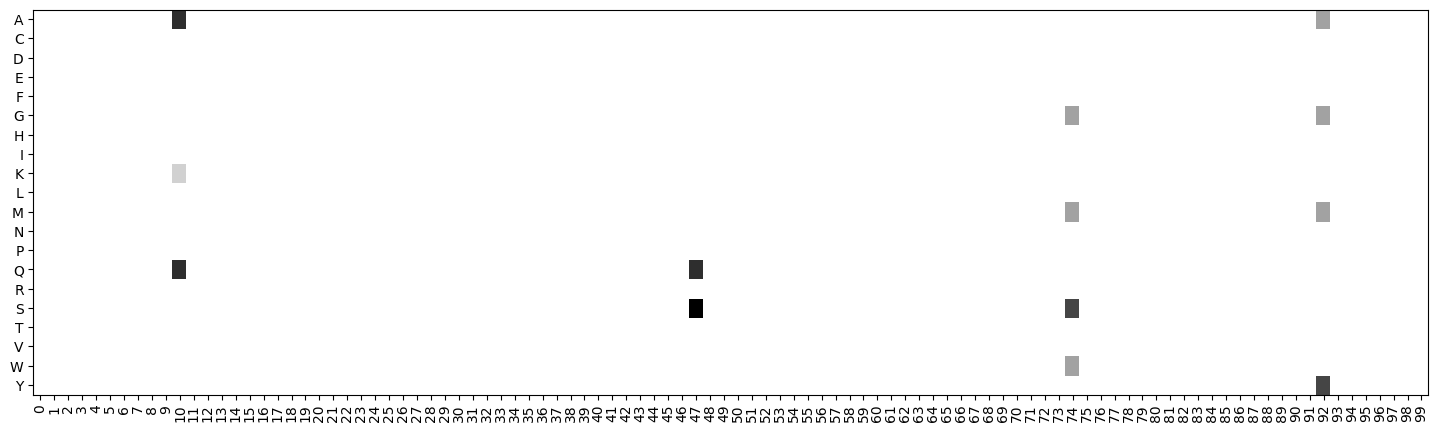

In [3]:
plt.figure(figsize = (18,5))
plt.imshow(sold_mat_df, aspect = 'auto', cmap = 'grey_r') 
_  = plt.xticks(range(length_of_protein), rotation = 90)
_  = plt.yticks(range(len(AMINO_ACIDS)), AMINO_ACIDS)


In [4]:
S = doe_utils.SOLD(sold_mat_df)
seqs, mutations = S.generate_sequences(10000)
seqs = np.unique(seqs)
print(len(seqs))
probs = S.compute_prob_n_mutations(num_mutated+1)

96


In [5]:
S.mutation_probs_variable_region_indexed

defaultdict(None,
            {0: {'A': 0.45, 'K': 0.1, 'Q': 0.45},
             1: {'Q': 0.45, 'S': 0.55},
             2: {'G': 0.2, 'M': 0.2, 'S': 0.4, 'W': 0.2},
             3: {'A': 0.2, 'G': 0.2, 'M': 0.2, 'Y': 0.4}})

# Now you have variable length mat to create encoder 

In [6]:
Q = doe_utils.Encoding_basics(S.mutation_probs_variable_region_indexed)



In [7]:
len(Q.feature_names_pairwise)

62

In [8]:
len(Q.pairwise_code_mapper)

6

In [9]:
Q.encode_parent_pairwise

[array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

In [10]:
Q.code_length_pairwise

np.int64(56)

In [11]:
E = doe_utils.Sequence_encoder_simplex(S.mutation_probs_variable_region_indexed)
independent_codes, pairwise_codes, flatten_independent, flatter_pairwise = E.encode_seqs(seqs)

In [12]:
model = doe_utils.Create_in_silico_model(S.mutation_probs_variable_region_indexed)

(array([ 2.,  5., 11., 12., 25., 20., 10.,  6.,  2.,  3.]),
 array([-5.0268882 , -4.05404241, -3.08119661, -2.10835081, -1.13550502,
        -0.16265922,  0.81018657,  1.78303237,  2.75587816,  3.72872396,
         4.70156976]),
 <BarContainer object of 10 artists>)

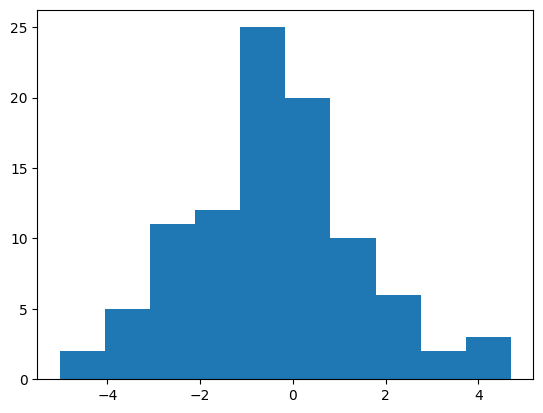

In [13]:
responses = model.model(flatten_independent, flatter_pairwise)
plt.hist(responses)

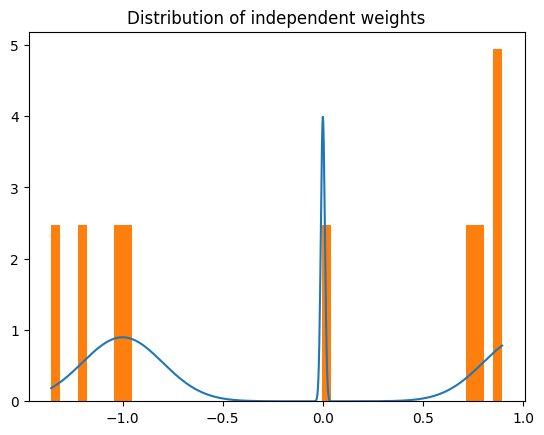

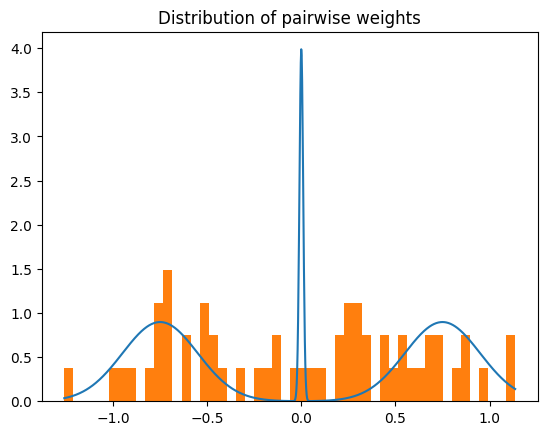

In [14]:
model.plot_weights()

In [15]:
fit_model = doe_utils.Fitting_model(S.mutation_probs_variable_region_indexed)
weights, fit_responses = fit_model.fit(seqs, responses, fit = 'both')

AttributeError: 'Fitting_model' object has no attribute 'pairwise_constraints'

In [16]:
fit_model.encoder.pairwise_constraints

array([[0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0

In [ ]:
plt.scatter(fit_responses, responses)

In [ ]:
plt.scatter(model.independent_weights, weights[fit_model.independent_indices])

In [ ]:
plt.scatter(model.pairwise_weights, weights[fit_model.pairwise_indices])

In [ ]:
a, b = np.linalg.eig(fit_model.features.T.dot(fit_model.features))

In [ ]:
plt.plot(a)

In [ ]:
model.pairwise_weights

In [ ]:
doe_utils._fix_pairwise_weights(model.pairwise_weights, model.pairwise_constraints)
    

In [ ]:
Q.pairwise_constraints.dot(model.pairwise_weights)